### Part 1

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
import pandas as pd
import numpy as np
import re
import patoolib
import csv
import string
import matplotlib.pyplot as plt
%matplotlib inline
import fasttext
from io import StringIO
import sklearn.model_selection
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

# Handling the dataset

In [8]:
df = pd.read_csv("/content/drive/MyDrive/datasetV3.csv")
df = df.astype(str)

In [9]:
def clean(text):
    try:
        text = re.sub('[^A-Za-z]+', ' ', text)
        return text
    except:
        return ""

In [10]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [11]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

In [12]:
for i in range(10):
    df['Cleaned_tweet' + str(i)] = [clean(x) for x in df['tweet' + str(i)].values];
    df['POS_tagged_tweet' + str(i)] = [token_stop_pos(x) for x in df['Cleaned_tweet' + str(i)].values];

In [13]:
for i in range(10):
    df['Lemma_tweet' + str(i)] = [lemmatize(x) for x in df['POS_tagged_tweet' + str(i)].values];

### Dataset for Fasttext training

In [14]:
df_data=pd.read_csv(r'/content/drive/MyDrive/data16.csv', encoding= 'latin1', header=None, usecols=[0,5])
df_data.columns = ["sentiment", "tweet"]

In [15]:
tweets = np.array(df_data["tweet"]);
tweets = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split()) for tweet in tweets]
df_data["tweet"] = tweets
df_data["sentiment"] = df_data["sentiment"].replace(4,1)
df_data = df_data.sample(frac = 1)
df_data = df_data.astype(str)

In [16]:
df_data["sentiment"] = df_data["sentiment"].replace(' ', '_', regex=True)
df_data["sentiment"]=['__label__'+s.replace(' or ', '$').replace(', or ','$').replace(',','$').replace(' ','_').replace(',','__label__').replace('$$','$').replace('$',' __label__').replace('___','__') for s in df_data["sentiment"]]

df_data["tweet"]= df_data["tweet"].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
df_data.to_csv(r'df_text.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

train_df,test_df = sklearn.model_selection.train_test_split(df_data, stratify=df_data["sentiment"], test_size=0.2)
train_df.to_csv(r'df_train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
test_df.to_csv(r'df_valid.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

# Building functions 

### Using TextBlob

In [17]:
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [18]:
for i in range(10):
    df['TextBlob_Polarity' + str(i)] = [getPolarity(x) for x in df['Lemma_tweet' + str(i)]]

In [19]:
df['Average_TextBlob_Polarity'] = df.iloc[:,-10:].mean(axis=1)

### Using VADER

In [20]:
analyzer = SentimentIntensityAnalyzer()
def Vader_scores(tweet):
    try:
        return analyzer.polarity_scores(tweet)
    except:
        return {'pos':0, 'neg':0, 'neu':0, 'compound':0}

In [21]:
for i in range(10):
    scores = [Vader_scores(x) for x in df['tweet' + str(i)]]
    df['Vader_neg' + str(i)] = [x['neg'] for x in scores]
    df['Vader_neu' + str(i)] = [x['neu'] for x in scores]
    df['Vader_pos' + str(i)] = [x['pos'] for x in scores]
    df['Vader_compound' + str(i)] = [x['compound'] for x in scores]

In [22]:
df['Average_Vader_neg'] = df[(list(df.filter(regex='Vader_neg')))].mean(axis=1)
df['Average_Vader_neu'] = df[(list(df.filter(regex='Vader_neu')))].mean(axis=1)
df['Average_Vader_pos'] = df[(list(df.filter(regex='Vader_pos')))].mean(axis=1)
df['Average_Vader_compound'] = df[(list(df.filter(regex='Vader_compound')))].mean(axis=1)

### Using Fasttext

In [23]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 33.03 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
/content/fastText
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-l

In [24]:
# Put 80% in df_text and 20% in df_valid
!head -n 1280000 df_text.txt > df_train.txt
!tail -n 320000 df_text.txt > df_valid.txt

In [25]:
!./fasttext supervised -input ./df_train.txt -output sent_model -autotune-validation ./df_valid.txt

Progress: 100.0% Trials:    3 Best score:  0.807969 ETA:   0h 0m 0s
Training again with best arguments
Read 19M words
Number of words:  332758
Number of labels: 2
Progress: 100.0% words/sec/thread:   35127 lr:  0.000000 avg.loss:  0.459381 ETA:   0h 0m 0s


In [26]:
model = fasttext.load_model("sent_model.bin")

In [27]:
def print_results(model, input_path, k):
    num_records, precision_at_k, recall_at_k = model.test(input_path, k)
    f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)

    print("records\t{}".format(num_records))
    print("Precision@{}\t{:.3f}".format(k, precision_at_k))
    print("Recall@{}\t{:.3f}".format(k, recall_at_k))
    print("F1@{}\t{:.3f}".format(k, f1_at_k))
    print()

In [28]:
print('train metrics:')
print_results(model, 'df_train.txt', 1)

print('test metrics:')
print_results(model,'df_valid.txt', 1)

train metrics:
records	1280000
Precision@1	0.821
Recall@1	0.821
F1@1	0.821

test metrics:
records	320000
Precision@1	0.808
Recall@1	0.808
F1@1	0.808



In [29]:
for i in range(10):
    values1 = [model.predict(x,2) for x in df['tweet' + str(i)].values];
    x = [list(value) for value in values1]
    for index,ele in enumerate(x):
        ele[0] = list(ele[0])
        if ele[0][0][-1] == '1':
            ele[0][0],ele[0][1] = ele[0][1],ele[0][0]
            ele[1][0],ele[1][1] = ele[1][1],ele[1][0]
    df['tweet' + str(i) + '_fasttext_positive_prob'] = [y[1][1] for y in x]
    df['tweet' + str(i) + '_fasttext_negative_prob'] = [y[1][0] for y in x]

In [30]:
df['Average_fasttext_positive_prob'] = df[(list(df.filter(regex='fasttext_positive_prob')))].mean(axis=1)
df['Average_fasttext_negative_prob'] = df[(list(df.filter(regex='fasttext_negative_prob')))].mean(axis=1)

####Final Dataset

In [31]:
df_final = df.loc[:,list(df.filter(regex='Average'))]
df_final = pd.concat([df.loc[:,["Data","Date","Time"]],df_final],axis=1)
df_final

,Data,Date,Time,Average_TextBlob_Polarity,Average_Vader_neg,Average_Vader_neu,Average_Vader_pos,Average_Vader_compound,Average_fasttext_positive_prob,Average_fasttext_negative_prob
0,tuesdayvibes,7/14/2020,7:00:21,0.171856,0.0229,0.8450,0.1321,0.09400,0.694402,0.305618
1,realmeC11,7/14/2020,7:00:21,0.211221,0.0184,0.9191,0.0625,0.15109,0.443586,0.556434
2,KPSharmaOli,7/14/2020,7:00:21,-0.091250,0.0933,0.8070,0.0997,-0.01938,0.616300,0.383720
3,RheaChakraborty,7/14/2020,7:00:21,0.050000,0.1047,0.7368,0.1587,0.18638,0.675596,0.324424
4,Stop_Transfer_Sunita_Yadav,7/14/2020,7:00:21,0.140952,0.1772,0.6803,0.1424,0.04834,0.747066,0.252954
...,...,...,...,...,...,...,...,...,...,...
35261,SwaraBhasker,9/14/2020,13:00:01,0.028244,0.0891,0.8227,0.0883,0.04122,0.491158,0.508862
35262,TukdeTukdeGang,9/14/2020,13:00:01,0.007088,0.1064,0.7659,0.1276,0.02968,0.480902,0.519118
35263,IndooKiJawani,9/14/2020,13:00:01,0.166667,0.0474,0.8340,0.1186,0.21012,0.773183,0.226837
35264,DelhiRiots2020,9/14/2020,13:00:01,0.235357,0.0671,0.8759,0.0569,0.04645,0.582829,0.417191


In [32]:
df_final.to_excel('database_final.xlsx')

### Part 2

# Plots

In [70]:
labels=["Positive","Neutral","Negative"]

In [47]:
def func(x):
    if(x>0.1):
        return "Positive"
    elif(x<-0.1):
        return "Negative"
    else:
        return "Neutral"

In [65]:
df_final["Average_fasttext"]=df_final["Average_fasttext_positive_prob"]-df_final["Average_fasttext_negative_prob"]

In [61]:
df_final["TextBlob"]=[func(x) for x in df_final['Average_TextBlob_Polarity']]
df_final["Vader"]=[func(x) for x in df_final['Average_Vader_compound']]
df_final["Fasttext"]=[func(x) for x in df_final['Average_fasttext']]

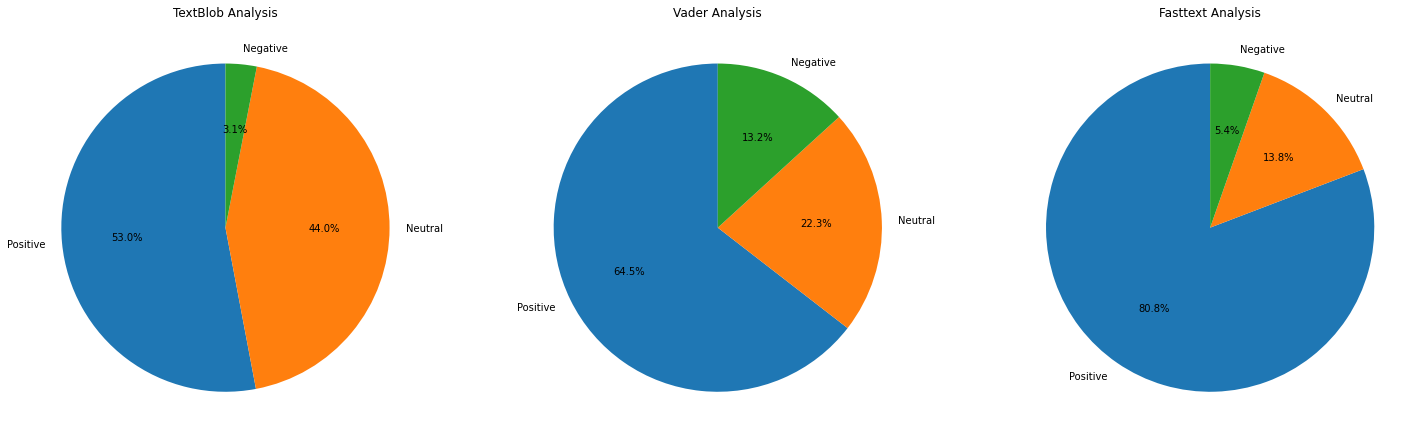

In [117]:
fig = plt.subplots(1,3,figsize=(25,25)) 
plt.subplot(1,3,1)
plt.pie(df_final['TextBlob'].value_counts(), labels= labels, startangle=90, autopct='%.1f%%')
plt.title('TextBlob Analysis')

plt.subplot(1,3,2)
plt.pie(df_final['Vader'].value_counts(), labels= labels, startangle=90, autopct='%.1f%%')
plt.title('Vader Analysis')

plt.subplot(1,3,3)
plt.pie(df_final['Fasttext'].value_counts(), labels= labels, startangle=90, autopct='%.1f%%')
plt.title('Fasttext Analysis')
plt.show()

In [185]:
df_final['Day']=pd.to_datetime(df_final['Date']).dt.day_name()
days = df_final['Day'].value_counts().index.to_list()

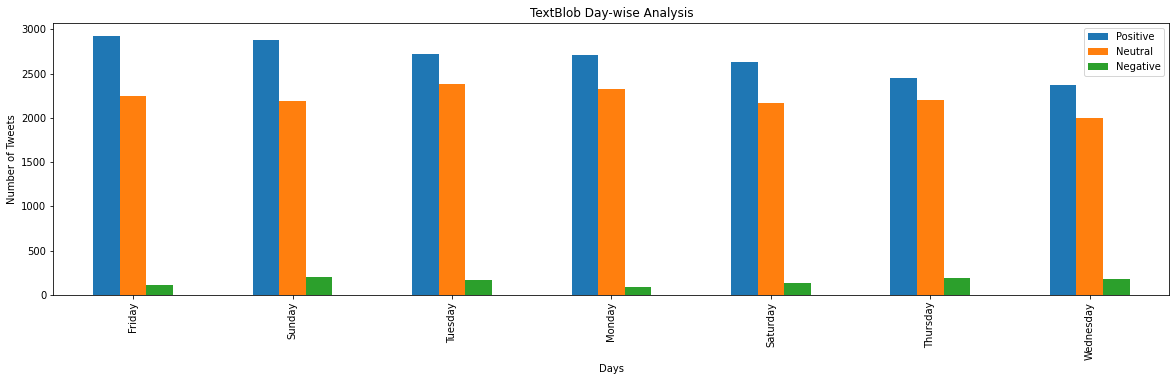

In [189]:
x = df_final.groupby('Day')["TextBlob"].value_counts()
plotdata = pd.DataFrame({
    "Positive" : [x[day][0] for day in days],
    "Neutral" : [x[day][1] for day in days],
    "Negative" : [x[day][2] for day in days]
    }, 
    index=days
)
plotdata.plot(kind="bar",figsize = (20,5))
plt.title("TextBlob Day-wise Analysis")
plt.xlabel("Days")
plt.ylabel("Number of Tweets")
plt.show()

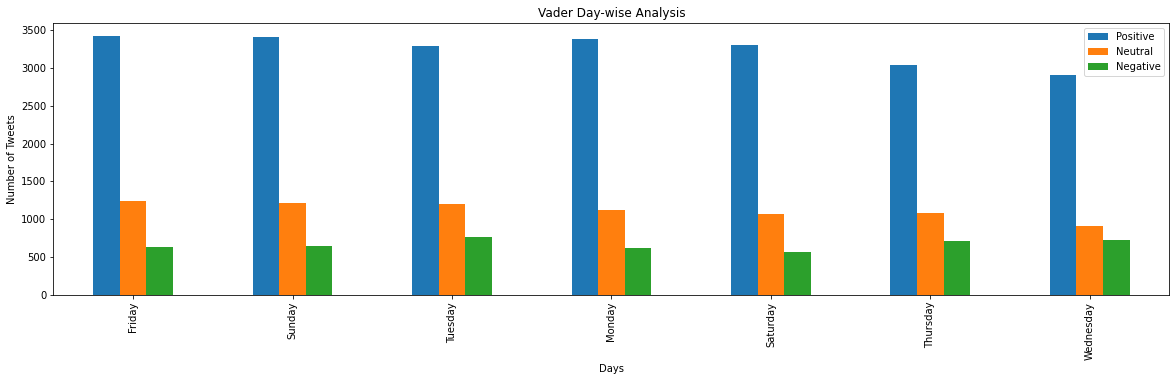

In [191]:
x = df_final.groupby('Day')["Vader"].value_counts()
plotdata = pd.DataFrame({
    "Positive" : [x[day][0] for day in days],
    "Neutral" : [x[day][1] for day in days],
    "Negative" : [x[day][2] for day in days]
    }, 
    index=days
)
plotdata.plot(kind="bar",figsize = (20,5))
plt.title("Vader Day-wise Analysis")
plt.xlabel("Days")
plt.ylabel("Number of Tweets")
plt.show()

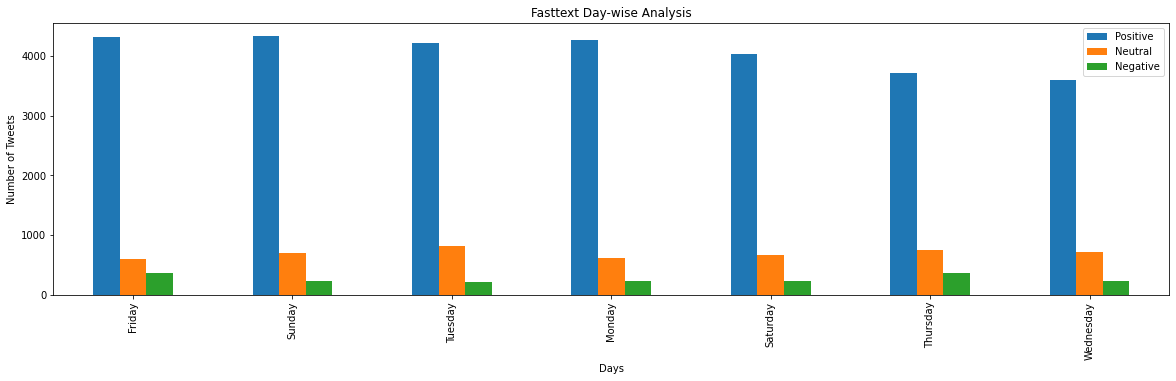

In [190]:
x = df_final.groupby('Day')["Fasttext"].value_counts()
plotdata = pd.DataFrame({
    "Positive" : [x[day][0] for day in days],
    "Neutral" : [x[day][1] for day in days],
    "Negative" : [x[day][2] for day in days]
    }, 
    index=days
)
plotdata.plot(kind="bar",figsize = (20,5))
plt.title("Fasttext Day-wise Analysis")
plt.xlabel("Days")
plt.ylabel("Number of Tweets")
plt.show()

# Conclusion 

We observe that sentiment analysis is very helpful while analysing tweets. We can easily look at a large amount of data and draw conclusions from it without actually reading through it all.